**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: Bag-of-Words Model

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/bow_guide.ipynb](guides/bow_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bow_guide` notebook

<br>

***

In [40]:
# imports for the project

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [41]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [42]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    
    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=0.01)
test_df = preprocess(test, frac=0.1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((1200, 2), (760, 2))

### 1.5 Inspect Data

In [43]:
words = train_df['text'].str.split().sum()

word_freq = {}
for word in words:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

print(word_freq)

{'US': 112, 'house': 6, 'sales': 23, 'fall': 14, 'in': 900, 'July': 3, 'Sales': 6, 'of': 1024, 'non-new': 1, 'houses': 2, 'the': 1835, 'fell': 20, 'last': 68, 'month': 11, 'but': 96, 'still': 17, 'exceeded': 1, 'analyst': 4, 'forecasts.': 1, 'DJ': 2, 'to': 1165, 'acquire': 5, 'MarketWatch': 2, 'Dow': 2, 'Jones': 3, 'amp;': 9, 'Co.,': 8, 'publisher': 4, 'Wall': 11, 'Street': 10, 'Journal,': 2, 'says': 37, 'it': 166, 'has': 195, 'agreed': 28, 'buy': 12, 'online': 14, 'news': 17, 'site': 11, 'Inc.': 56, 'a': 974, '\\$519': 1, 'million': 46, 'deal': 23, 'that': 266, 'widens': 1, 'its': 186, 'Internet': 31, 'audience.': 1, 'Dollar': 7, 'hits': 5, 'new': 108, 'low': 11, 'on': 519, 'Snow': 2, 'speech': 2, 'The': 252, 'United': 40, 'States': 22, 'supports': 1, 'quot;strong': 1, 'dollar,': 3, 'quot;': 45, 'Treasury': 2, 'Secretary': 6, 'John': 8, 'said,': 2, 'while': 21, 'suggesting': 2, 'Bush': 31, 'administration': 5, 'will': 126, 'not': 82, 'act': 5, 'boost': 5, 'value.': 1, 'His': 3, 'comme

In [44]:
def preprocess_text(word):


    # 1. Convert the text to lowercase
    word = word.lower()

    # 2. Remove punctuation by building a new string without those characters
    # Define punctuation characters explicitly (since we are not using any libraries)
    punctuation_chars = ".,!?;:'\"()"
    word = ''.join(char for char in word if char not in punctuation_chars)

    # 3. Tokenize by splitting on whitespace
    tokens = word.split()

    return tokens

# Process the document and print results
tokens = preprocess_text(train_df['text'].iloc[0])
print(tokens)


['us', 'house', 'sales', 'fall', 'in', 'july', 'sales', 'of', 'non-new', 'houses', 'in', 'the', 'us', 'fell', 'last', 'month', 'but', 'still', 'exceeded', 'analyst', 'forecasts']


In [45]:
preprocessed_documents = [preprocess_text(doc) for doc in train_df['text']]

print(f"{len(preprocessed_documents)=} | {len(train_df['text'])=}\n")
print(preprocessed_documents)

# Create word_freq = {}
for tokens in preprocessed_documents:
    for word in tokens:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

print(f"{len(word_freq)=}\n")
print(word_freq) # a dictionary to store the frequency of each word in the corpus


len(preprocessed_documents)=1200 | len(train_df['text'])=1200

[['us', 'house', 'sales', 'fall', 'in', 'july', 'sales', 'of', 'non-new', 'houses', 'in', 'the', 'us', 'fell', 'last', 'month', 'but', 'still', 'exceeded', 'analyst', 'forecasts'], ['dj', 'to', 'acquire', 'marketwatch', 'dow', 'jones', 'amp', 'co', 'publisher', 'of', 'the', 'wall', 'street', 'journal', 'says', 'it', 'has', 'agreed', 'to', 'buy', 'online', 'news', 'site', 'marketwatch', 'inc', 'in', 'a', '\\$519', 'million', 'deal', 'that', 'widens', 'its', 'internet', 'audience'], ['dollar', 'hits', 'new', 'low', 'on', 'snow', 'speech', 'the', 'united', 'states', 'supports', 'a', 'quotstrong', 'dollar', 'quot', 'treasury', 'secretary', 'john', 'snow', 'said', 'while', 'suggesting', 'the', 'bush', 'administration', 'will', 'not', 'act', 'to', 'boost', 'its', 'value', 'his', 'comments', 'sent', 'the', 'currency', 'plunging', 'to', 'a', 'record', 'low', 'against', 'the', 'euro'], ['yukos', 'executives', 'flee', 'russia', 'all'

In [46]:
def build_document_term_matrix(preprocessed_documents):
   
    # 1. Extract unique vocabulary from the dataset and sort it
    vocab = sorted(set(word for doc in preprocessed_documents for word in doc))

    # 2. Create a word-to-index mapping
    word_to_index = {word: idx for idx, word in enumerate(vocab)}

    print(word_to_index)

    # 3. Convert each document into a vector
    document_term_matrix = []
    
    for tokens in preprocessed_documents:
        doc_vector = [0] * len(vocab)  # Initialize a vector of zeros
        for token in tokens:
            if token in word_to_index:
                doc_vector[word_to_index[token]] += 1  # Increment word count
        document_term_matrix.append(doc_vector)

    print(f"\nVocabulary Size: {len(vocab)} | Number of Documents: {len(document_term_matrix)}\n")

    return document_term_matrix, vocab, word_to_index

document_term_matrix, vocab, word_to_index = build_document_term_matrix(preprocessed_documents)

{'#146ve': 0, '#147a': 1, '#147i': 2, '#147marvel': 3, '#147nothing': 4, '#147the': 5, '#148': 6, '#151': 7, '#225vez': 8, '#361': 9, '#3610': 10, '#36100': 11, '#36109': 12, '#36125': 13, '#3613': 14, '#36136': 15, '#36136b': 16, '#3615': 17, '#3619': 18, '#363': 19, '#3637': 20, '#36440': 21, '#3646': 22, '#3675': 23, '#39': 24, '#3904': 25, '#39a': 26, '#39afar': 27, '#39collaborator': 28, '#39crescent': 29, '#39d': 30, '#39don': 31, '#39fully': 32, '#39genocide': 33, '#39get': 34, '#39grand': 35, '#39halo': 36, '#39holy': 37, '#39intelligent': 38, '#39iron': 39, '#39is': 40, '#39isle': 41, '#39keefe': 42, '#39ll': 43, '#39m': 44, '#39neal': 45, '#39parasites': 46, '#39partner': 47, '#39phishers': 48, '#39re': 49, '#39reckless': 50, '#39ringer': 51, '#39rusty': 52, '#39s': 53, '#39survivor': 54, '#39t': 55, '#39tiger': 56, '#39to': 57, '#39torn': 58, '#39ve': 59, '#39very': 60, '#8212': 61, '#8217s': 62, '#8220atlantic': 63, '#8221': 64, '&lta': 65, '&ltb&gt&lt/b&gt': 66, '&ltbr&gt&

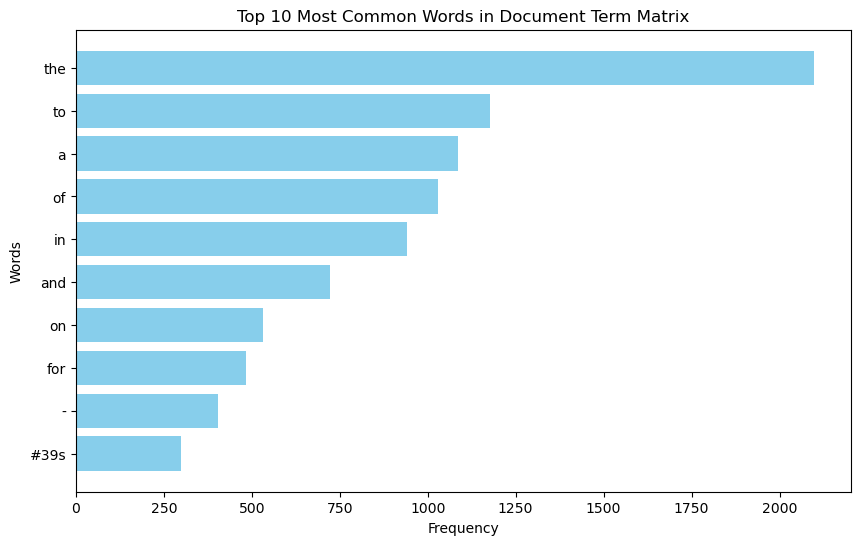

In [47]:

def visualize_top_n_tokens(n, document_term_matrix):

    # Sum the occurrences of each word across all documents
    word_counts = np.sum(document_term_matrix, axis=0)

    # Get the indices of the top n most common words
    top_n_indices = np.argsort(word_counts)[-n:]

    # Get the corresponding words and their counts
    top_n_words = [vocab[i] for i in top_n_indices]
    top_n_counts = word_counts[top_n_indices]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words in Document Term Matrix')
    plt.show()

visualize_top_n_tokens(10, document_term_matrix)

### 2. Transform Data

In [48]:
(
    X_train,
    X_val,
    y_train,
    y_val

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(960,) (240,) (960,) (240,)


In [60]:
stop_words = list(ENGLISH_STOP_WORDS)
print(stop_words)

['them', 'ever', 'their', 'do', 'she', 'cannot', 'each', 'please', 're', 'whatever', 'already', 'nor', 'whom', 'detail', 'without', 'after', 'becomes', 'ten', 'through', 'so', 'see', 'for', 'couldnt', 'down', 'until', 'however', 'fifteen', 'hereby', 'only', 'thereupon', 'we', 'few', 'you', 'hence', 'should', 'found', 'had', 'where', 'seem', 'me', 'sometime', 'must', 'yours', 'toward', 'yourself', 'can', 'put', 'indeed', 'bill', 'due', 'while', 'others', 'own', 'further', 'between', 'whence', 'sixty', 'it', 'all', 'rather', 'still', 'get', 'even', 'forty', 'ltd', 'many', 'with', 'since', 'which', 'may', 'one', 'enough', 'both', 'together', 'nine', 'nothing', 'else', 'whereas', 'been', 'either', 'along', 'third', 'wherever', 'herself', 'part', 'full', 'into', 'because', 'done', 'whereupon', 'among', 'often', 'thick', 'same', 'am', 'twelve', 'thin', 'describe', 'yourselves', 'nevertheless', 'moreover', 'etc', 'anything', 'be', 'an', 'eg', 'not', 'as', 'his', 'some', 'much', 'off', 'severa

In [74]:
# countvectorizer
cv = CountVectorizer(stop_words=stop_words, token_pattern=r"(?u)\b\w+\b", ngram_range=(1,4))
X_train_vectorized = cv.fit_transform(X_train)

In [75]:
X_train_vectorized.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

### 3. Train Model

In [76]:
# List of classifiers to test out model performance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['l2'], 
    'solver': ['liblinear', 'saga'],  
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
}

# Baseline models
LR = LogisticRegression(max_iter=1000, random_state=42)
RF = RandomForestClassifier(random_state=42)


# GridSearch function
LR_Grid_Search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
RF_Grid_Search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train the models
LR.fit(X_train_vectorized, y_train)
RF.fit(X_train_vectorized, y_train)
LR_Grid_Search.fit(X_train_vectorized, y_train)
RF_Grid_Search.fit(X_train_vectorized, y_train)

print(f"Best Logistic Regression Parameters: {LR_Grid_Search.best_params_}")
print(f"Best Random Forest Parameters: {RF_Grid_Search.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.3s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.4s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .....................C=0.1, penalty=l2, 

In [77]:
X_val_vectorized = cv.transform(X_val) # note that we use transform here, not fit_transform

# Get the best classifiers
best_LR = LR_Grid_Search.best_estimator_
best_RF = RF_Grid_Search.best_estimator_

# Predict the validation set
LR.predict(X_val_vectorized)
RF.predict(X_val_vectorized)
y_pred_LR = best_LR.predict(X_val_vectorized)
y_pred_RF = best_RF.predict(X_val_vectorized)

# Print input and output of the model
print(X_val[:5])

# Print sample instance of predicted output 
print(y_pred_LR[:5])
print(y_pred_RF[:5])

1178    At least 166 miners trapped, feared dead in Ch...
865     Petacchi sprints to third victory VALENCIA, Sp...
101     Update 2: Volkswagen, Workers Renew Wage Talks...
439     German bank customers victims of phishing FRAN...
58      Stocks Rise; Healthcare Sector Climbs  NEW YOR...
Name: text, dtype: object
['World' 'Sports' 'Business' 'Business' 'Business']
['World' 'Sports' 'Business' 'Sci/Tech' 'Business']


### 4. Evaluate Model

In [78]:
# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_LR))

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_RF))

# Overview of performance on Validation Set
print("Baseline Logistic Regression Accuracy: ", LR.score(X_val_vectorized, y_val))
print("Baseline Random Forest Accuracy: ", RF.score(X_val_vectorized, y_val))
print("Logistic Regression Accuracy: ", best_LR.score(X_val_vectorized, y_val))
print("Random Forest Accuracy: ", best_RF.score(X_val_vectorized, y_val))





Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Business       0.79      0.68      0.73        62
    Sci/Tech       0.75      0.65      0.70        60
      Sports       0.79      0.90      0.84        60
       World       0.76      0.88      0.82        58

    accuracy                           0.78       240
   macro avg       0.77      0.78      0.77       240
weighted avg       0.77      0.78      0.77       240

Random Forest Classification Report:
              precision    recall  f1-score   support

    Business       0.80      0.63      0.70        62
    Sci/Tech       0.72      0.68      0.70        60
      Sports       0.77      0.88      0.82        60
       World       0.74      0.83      0.78        58

    accuracy                           0.75       240
   macro avg       0.76      0.76      0.75       240
weighted avg       0.76      0.75      0.75       240

Baseline Logistic Regression Accuracy:  0.75
Basel

In [79]:
test_df_vectorized = cv.transform(test_df["text"])

y_test = test_df["label"]

LR.predict(test_df_vectorized)
RF.predict(test_df_vectorized)
y_pred_LR_test = best_LR.predict(test_df_vectorized)
y_pred_RF_test = best_RF.predict(test_df_vectorized)

print("Logistic Regression Test Set Performance:")
print(classification_report(y_test, y_pred_LR_test))

print("Random Forest Test Set Performance:")
print(classification_report(y_test, y_pred_RF_test))

print("Baseline Logistic Regression Test Set Performance:", LR.score(test_df_vectorized, y_test))
print("Baseline Random Forest Test Set Performance:", RF.score(test_df_vectorized, y_test))
print("Logistic Regression Test Set Performance:", best_LR.score(test_df_vectorized, y_test))
print("Random Forest Test Set Performance:", best_RF.score(test_df_vectorized, y_test))

Logistic Regression Test Set Performance:
              precision    recall  f1-score   support

    Business       0.81      0.77      0.79       190
    Sci/Tech       0.85      0.77      0.81       190
      Sports       0.86      0.93      0.90       190
       World       0.82      0.87      0.85       190

    accuracy                           0.84       760
   macro avg       0.84      0.84      0.84       760
weighted avg       0.84      0.84      0.84       760

Random Forest Test Set Performance:
              precision    recall  f1-score   support

    Business       0.85      0.74      0.79       190
    Sci/Tech       0.79      0.81      0.80       190
      Sports       0.85      0.90      0.87       190
       World       0.82      0.84      0.83       190

    accuracy                           0.82       760
   macro avg       0.82      0.82      0.82       760
weighted avg       0.82      0.82      0.82       760

Baseline Logistic Regression Test Set Performance: 0